<a href="https://colab.research.google.com/github/CarolinRi/CorneaAI/blob/main/Clustering_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install data-science-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pandas.plotting import parallel_coordinates

from ds_utils.unsupervised import plot_cluster_cardinality
from ds_utils.unsupervised import plot_cluster_magnitude
from scipy.spatial.distance import euclidean
from ds_utils.unsupervised import plot_magnitude_vs_cardinality

from sklearn import metrics
from sklearn.metrics import pairwise_distances


In [3]:
#loading data from github
url = 'https://raw.githubusercontent.com/CarolinRi/CorneaAI/main/Corneae.csv'
data = pd.read_csv(url)

data.head()

,name,Sa,Sz,Str,Spc,Sdr,Sq,Ssk,Sku,Sp,...,Spk,Svk,Smr1,Smr2,Sxp,Vvv,Vvc,Vmp,Vmc,Area size
0,Image1,2.614,274.947,0.748,618.077,0.4713,4.268,-0.695,43.153,95.619,...,6.299,6.606,14.409,84.385,7.875,0.631,3.514,0.346,2.387,5698488.305
1,Image2,2.322,109.784,0.795,493.983,0.2420,3.322,-0.136,8.819,28.445,...,4.749,4.769,14.482,86.266,7.084,0.463,3.451,0.243,2.304,5698488.305
2,Image3,2.290,144.892,0.672,483.631,0.1903,3.474,0.216,15.627,88.407,...,5.313,4.879,14.828,85.769,7.172,0.469,3.361,0.282,2.202,5698488.305
3,Image4,3.773,365.166,0.646,733.252,0.7382,6.251,0.782,27.244,182.826,...,10.205,9.136,14.988,83.627,12.522,0.881,5.098,0.576,3.413,5698488.305
4,Image5,2.926,77.283,0.619,642.364,0.4652,4.076,-0.021,6.527,32.810,...,5.771,5.483,12.838,87.238,8.604,0.535,4.317,0.293,3.007,5698488.305


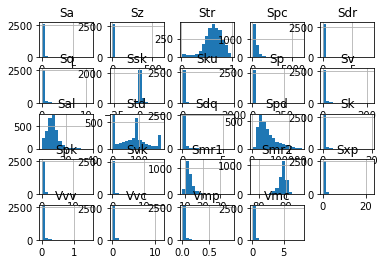

In [4]:
# defining and scaling evidence and defining labels
to_drop = ['name', 'Area size']
evidence = data.drop(columns = to_drop)

# to_keep = ['Str', 'Ssk', 'Sku', 'Sal', 'Std', 'Smr1', 'Smr2', 'Sq', 'Sdr']
# evidence = data[to_keep]

evidence.hist(bins=15)
evidence = evidence.values.tolist()

scaler = MinMaxScaler()
evidence = scaler.fit_transform(evidence)

labels = data['name']
labels = labels.values.tolist()


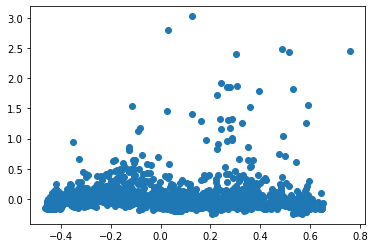

In [5]:
# principal component analysis

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(evidence.copy()))
plt.scatter(transformed[:][0],transformed[:][1])


**1. K means clustering**

- centroid-based

1.1 Elbow method to identify the optimal number of clusters

The number of clusters is varied from 1 to 10 and the WCSS (Within-Cluster Sum of Square) wird berechnet. Die Elbow-shaped Kurve hat einen Punkt, an dem sich die Steigung der Kurven drastisch ändert. Dieser Punkt, der "Ellenbogen", wird als die ideale Anzahl an Clustern gesehen.

1.2 Generate model and plot cluster result in reduced dimensions

1.3 Get evaluation metrics

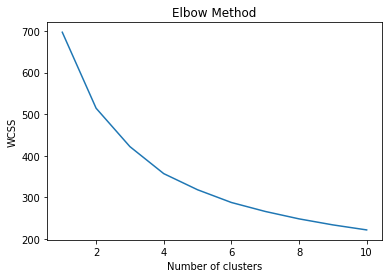

In [6]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=None)
    kmeans.fit(evidence)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

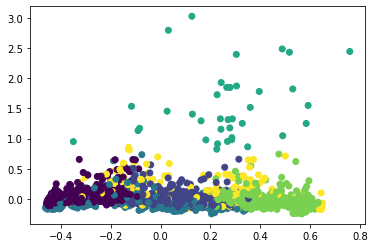

In [22]:
# performing k means clustering with 4 clusters
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit(evidence)

# print(pred_y.labels_)

# distances = pred_y.transform(evidence)

# print(distances)

# centers = kmeans.cluster_centers_
# transformed_centers = pca.transform(centers)
plt.scatter(transformed[:][0],transformed[:][1],c=pred_y.labels_.astype(float))
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

**1. Cluster cardinality**

Cluster cardinality is the number of examples per cluster

**2. Cluster magnitude**

Cluster magnitude is the sum of distances from all examples to the centroid of the cluster.

**3. Silhouette Coefficient**

high coeff: well defined clusters

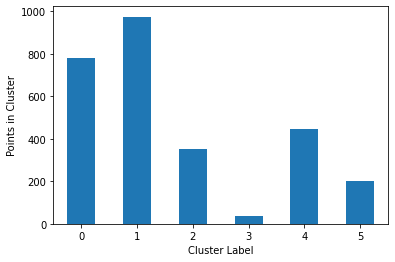

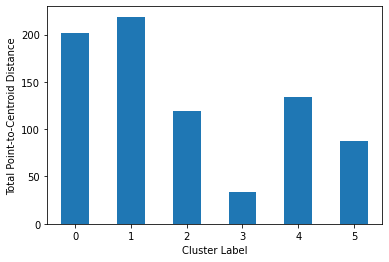

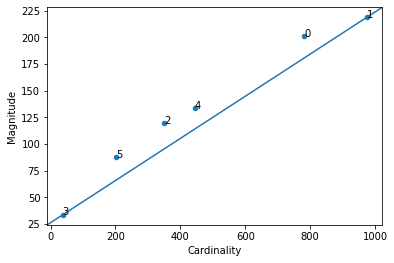

0.27494821590564233 790.9105422599475 1.2322784678179526


In [23]:
plot_cluster_cardinality(pred_y.labels_)

plot_cluster_magnitude(evidence, pred_y.labels_, pred_y.cluster_centers_,euclidean)

plot_magnitude_vs_cardinality(evidence, pred_y.labels_, pred_y.cluster_centers_, euclidean)

plt.show()

# metrics.silhouette_score(evidence, pred_y.labels_, metric='euclidean')

Sil = metrics.silhouette_score(evidence, pred_y.labels_, metric='euclidean')
CH = metrics.calinski_harabasz_score(evidence, pred_y.labels_)
DB = metrics.davies_bouldin_score(evidence, pred_y.labels_)

print(Sil, CH, DB)